In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import os

import random
import gc

In [8]:
def initialize_c_corner_deleted(num_grid_, num_side_, scale_factor_):
    c = np.zeros((num_grid_+2, num_grid_+2, num_side_), dtype = np.float64)
        
    # setting side value
    for i in range(num_grid_-2):
        c[0+1, 0+1+1+i, 1] = 0.375/scale_factor_ # right side of upper side
        c[0+1, 0+1+1+i, 3] = 0.375/scale_factor_ # left side of upper side
        c[0+1, 0+1+1+i, 2] = 0.25/scale_factor_ # down side of upper side
    for i in range(num_grid_-2):
        c[num_grid_, 0+1+1+i, 1] = 0.375/scale_factor_ # right side of bottom side
        c[num_grid_, 0+1+1+i, 3] = 0.375/scale_factor_ # left side of bottom side
        c[num_grid_, 0+1+1+i, 0] = 0.25/scale_factor_ # upper side of bottom side
    for i in range(num_grid_-2):
        c[0+1+1+i, num_grid_, 0] = 0.375/scale_factor_ # upper side of right side
        c[0+1+1+i, num_grid_, 2] = 0.375/scale_factor_ # bottom side of right side
        c[0+1+1+i, num_grid_, 3] = 0.25/scale_factor_ # left side of right side
    for i in range(num_grid_-2):
        c[0+1+1+i, 0+1, 0] = 0.375/scale_factor_ # upper side of left side
        c[0+1+1+i, 0+1, 2] = 0.375/scale_factor_ # bottom side of left side
        c[0+1+1+i, 0+1, 1] = 0.25/scale_factor_ # right side of left side
    
    # connecting corner
    c[1, 1, 1] = c[1, 1, 2] = 0.375/scale_factor_ # upper left
    c[1, num_grid_, 2] = c[1, num_grid_, 3] = 0.375/scale_factor_ # upper right
    c[num_grid_, 1, 0] = c[num_grid_, 1, 1] = 0.375/scale_factor_ # bottom left
    c[num_grid_, num_grid_, 0] = c[num_grid_, num_grid_, 3] = 0.375/scale_factor_ # bottom right
    
    # setting most of the grid
    for i in range(num_grid_-2):
        for j in range(num_grid_-2):
            for k in range(4):
                c[i+2, j+2, k] = 0.25/scale_factor_
    
    #print(c)
    return c
    
c = initialize_c_corner_deleted(9, 4, 100)
#print(c)

In [2]:
def gain_function_(z, alpha):
    return alpha * math.log(1 + math.exp(z/alpha))

def single_population_rate_model_(E_t, u_t, x_t, z_t, J, alpha, tau, E_0_default, Ext_input, t_fac, t_d, t_th, thre_effi, U, dt):
    du = (U - u_t) / t_fac + U * (1 - u_t) * E_t    
    dE = (- E_t + gain_function_((J * u_t * x_t * E_t + E_0_default + Ext_input - thre_effi * z_t), alpha)) / tau
    dx = (1 - x_t) / t_d - u_t * x_t * E_t
    dz = (E_t - z_t)/t_th
    
    E_t_ = E_t + dE * dt
    x_t_ = x_t + dx * dt
    u_t_ = u_t + du * dt
    z_t_ = z_t + dz * dt
    return E_t_, u_t_, x_t_, z_t_

def init_dynamical_variable_and_time_with_memory_reset(num_grid, T, E_ini, u_ini, x_ini, z_ini, memory_reset_timng):
    
    time = np.zeros(int(memory_reset_timng*(1/dt)))
    E_t = np.zeros((int(memory_reset_timng*(1/dt)), num_grid + 2, num_grid + 2), dtype = np.float64)
    u_t = np.zeros((int(memory_reset_timng*(1/dt)), num_grid + 2, num_grid + 2), dtype = np.float64)
    x_t = np.zeros((int(memory_reset_timng*(1/dt)), num_grid + 2, num_grid + 2), dtype = np.float64)
    z_t = np.zeros((int(memory_reset_timng*(1/dt)), num_grid + 2, num_grid + 2), dtype = np.float64)
    
    # E_t[time_index, grid_index_i, grid_index_j]
    E_t[0, :, :] = E_ini
    # E_t[:, 0, :] and E_t[:, num_grid + 1, :] and E_t[:, :, 0] and E_t[:, :, num_grid + 1] is boundary. 
    # this value has no physical meaning.
    if E_ini != 0:
        E_t[:, 0, :] = E_t[:, num_grid + 1, :] = E_t[:, :, 0] = E_t[:, :, num_grid + 1] = 0
    
    u_t[0, :, :] = u_ini
    if u_ini != 0:
        u_t[:, 0, :] = u_t[:, num_grid + 1, :] = u_t[:, :, 0] = u_t[:, :, num_grid + 1] = 0
    x_t[0, :, :] = x_ini
    if x_ini != 0:
        x_t[:, 0, :] = x_t[:, num_grid + 1, :] = x_t[:, :, 0] = x_t[:, :, num_grid + 1] = 0
    z_t[0, :, :] = z_ini
    #print(E_t, u_t, x_t, z_t)
    return time, E_t, u_t, x_t, z_t

In [92]:
def start_simulation_with_gc(T, num_grid, time, E_t, u_t, x_t, z_t, J, alpha, tau, E_0_default, t_fac, t_d, t_th, thre_effi, U, dt, injection_time, injection_i, injection_j, injection_value, memory_reset_timing):
    print("starting sinulation\ngrid size {}*{} simulation time {}sec".format(num_grid, num_grid, int(T*dt)))
    print("parameters are following\ntau {} t_fac {} t_d {} t_th {} U {}".format(tau, t_fac, t_d, t_th, U))
    print("J {} alpha {} thre_effi {}".format(J, alpha, thre_effi))
    print(E_t[0,:,:])
    #time = np.zeros(int(memory_reset_timing*(1/dt)))
    for i in range(int(T) - 1):
        time_index_in_reset = i%int(memory_reset_timing*(1/dt))
        #print("time index in reset {}".format(time_index_in_reset))
        #time[time_index_in_reset+1] = (time_index_in_reset+1) * dt
        #print("time_index_in_reset {} : {}".format(time_index_in_reset+1, time[time_index_in_reset+1]))
        #if time_index_in_reset+1 == int(memory_reset_timing*(1/dt)):
        if time_index_in_reset+1 == int(memory_reset_timing*(1/dt)):
            tmp_E_t = np.zeros((1, num_grid + 2, num_grid + 2), dtype = np.float64)
            tmp_x_t = np.zeros((1, num_grid + 2, num_grid + 2), dtype = np.float64)
            tmp_u_t = np.zeros((1, num_grid + 2, num_grid + 2), dtype = np.float64)
            tmp_z_t = np.zeros((1, num_grid + 2, num_grid + 2), dtype = np.float64)

            tmp_E_t = E_t[int(memory_reset_timing*(1/dt))-1,:,:]
            tmp_x_t = x_t[int(memory_reset_timing*(1/dt))-1,:,:]
            tmp_u_t = u_t[int(memory_reset_timing*(1/dt))-1,:,:]
            tmp_z_t = z_t[int(memory_reset_timing*(1/dt))-1,:,:]
            del E_t
            del x_t
            del u_t
            del z_t
            gc.collect()
            E_t = np.zeros((int(memory_reset_timing*(1/dt)), num_grid + 2, num_grid + 2), dtype = np.float64)
            x_t = np.zeros((int(memory_reset_timing*(1/dt)), num_grid + 2, num_grid + 2), dtype = np.float64)
            u_t = np.zeros((int(memory_reset_timing*(1/dt)), num_grid + 2, num_grid + 2), dtype = np.float64)
            z_t = np.zeros((int(memory_reset_timing*(1/dt)), num_grid + 2, num_grid + 2), dtype = np.float64)
            E_t[0,:,:] = tmp_E_t
            x_t[0,:,:] = tmp_x_t
            u_t[0,:,:] = tmp_u_t
            z_t[0,:,:] = tmp_z_t
            #print("x_t {}".format(x_t[0,:,:]))
            #print("z_t {}".format(z_t[0,:,:]))
            print(time)
        else:
            time[time_index_in_reset+1] = (time_index_in_reset+1) * dt
            if time_index_in_reset == 0:
                print("resetted i {}".format(int(i*dt)))
            for grid_index_i in range(num_grid):
                for grid_index_j in range(num_grid):                
                    E_t[time_index_in_reset+1, grid_index_i+1, grid_index_j+1], u_t[time_index_in_reset+1, grid_index_i+1, grid_index_j+1], x_t[time_index_in_reset+1, grid_index_i+1, grid_index_j+1]\
                    , z_t[time_index_in_reset+1, grid_index_i+1, grid_index_j+1] \
                    = single_population_rate_model_(E_t[time_index_in_reset, grid_index_i+1, grid_index_j+1], u_t[time_index_in_reset, grid_index_i+1, grid_index_j+1]\
                                        , x_t[time_index_in_reset, grid_index_i+1, grid_index_j+1], z_t[time_index_in_reset, grid_index_i+1, grid_index_j+1]\
                                        , J, alpha, tau, E_0_default\
                                        , c[grid_index_i+1-1, grid_index_j+1, 2] * E_t[time_index_in_reset, grid_index_i+1-1, grid_index_j+1] * u_t[time_index_in_reset, grid_index_i+1-1, grid_index_j+1] * x_t[time_index_in_reset, grid_index_i+1-1, grid_index_j+1]\
                                         +c[grid_index_i+1, grid_index_j+1+1, 3] * E_t[time_index_in_reset, grid_index_i+1, grid_index_j+1+1] * u_t[time_index_in_reset, grid_index_i+1, grid_index_j+1+1] * x_t[time_index_in_reset, grid_index_i+1, grid_index_j+1+1]\
                                         +c[grid_index_i+1+1, grid_index_j+1, 0] * E_t[time_index_in_reset, grid_index_i+1+1, grid_index_j+1] * u_t[time_index_in_reset, grid_index_i+1+1, grid_index_j+1] * x_t[time_index_in_reset, grid_index_i+1+1, grid_index_j+1]\
                                        +c[grid_index_i+1, grid_index_j+1-1, 1] * E_t[time_index_in_reset, grid_index_i+1, grid_index_j+1-1] * u_t[time_index_in_reset, grid_index_i+1, grid_index_j+1-1] * x_t[time_index_in_reset, grid_index_i+1, grid_index_j+1-1]\
                                        , t_fac, t_d, t_th, thre_effi, U, dt)
            # setting corner value
            E_t[time_index_in_reset+1, 1, 1], x_t[time_index_in_reset+1, 1, 1], u_t[time_index_in_reset+1, 1, 1] = (E_t[time_index_in_reset+1, 1, 2] + E_t[time_index_in_reset+1, 2, 1])/2, (x_t[time_index_in_reset+1, 1, 2] + x_t[time_index_in_reset+1, 2, 1])/2, (u_t[time_index_in_reset+1, 1, 2] + u_t[time_index_in_reset+1, 2, 1])/2 # upper left 
            #print("E_t[{}, 1, 1] = ({} + {})/2 = {}".format(i+1, E_t[i+1, 1, 2], E_t[i+1, 2, 1], E_t[i+1, 1, 1]))
            E_t[time_index_in_reset+1, 1, num_grid], x_t[time_index_in_reset+1, 1, num_grid], u_t[time_index_in_reset+1, 1, num_grid] = (E_t[time_index_in_reset+1, 2, num_grid]+E_t[time_index_in_reset+1, 1, num_grid-1])/2, (x_t[time_index_in_reset+1, 2, num_grid]+x_t[time_index_in_reset+1, 1, num_grid-1])/2, (u_t[time_index_in_reset+1, 2, num_grid]+u_t[time_index_in_reset+1, 1, num_grid-1])/2 # upper right
            E_t[time_index_in_reset+1, num_grid, 1], x_t[time_index_in_reset+1, num_grid, 1], u_t[time_index_in_reset+1, num_grid, 1] = (E_t[time_index_in_reset+1, num_grid, 2]+E_t[time_index_in_reset+1, num_grid-1, 1])/2, (x_t[time_index_in_reset+1, num_grid, 2]+x_t[time_index_in_reset+1, num_grid-1, 1])/2, (u_t[time_index_in_reset+1, num_grid, 2]+u_t[time_index_in_reset+1, num_grid-1, 1])/2 # bottom left
            E_t[time_index_in_reset+1, num_grid, num_grid], x_t[time_index_in_reset+1, num_grid, num_grid], u_t[time_index_in_reset+1, num_grid, num_grid] = (E_t[time_index_in_reset+1, num_grid-1, num_grid]+E_t[time_index_in_reset+1, num_grid, num_grid-1])/2, (x_t[time_index_in_reset+1, num_grid-1, num_grid]+x_t[time_index_in_reset+1, num_grid, num_grid-1])/2, (u_t[time_index_in_reset+1, num_grid-1, num_grid]+u_t[time_index_in_reset+1, num_grid, num_grid-1])/2 # bottom right
            #print(time[time_index_in_reset+1])
            if i+1 == int(injection_time*(1/dt)):
                E_t[time_index_in_reset+1, injection_i, injection_j] = injection_value
    print("simulation completed !")

def plot_results(plot_dpi, start_time, end_time):
    plt.clf()
    fig = plt.figure(figsize = (40, 10), dpi = plot_dpi)
    #index_grid_i = int((num_grid+1)/2)
    for index_grid_i in range(int((num_grid+1)/2)):
        for index_grid_j in range(int((num_grid+1)/2)):
            plt.plot(time[int(start_time*(1/dt)):int(end_time*(1/dt))], E_t[int(start_time*(1/dt)):int(end_time*(1/dt)),index_grid_i+1,index_grid_j+1], label="E_{}/{}".format(index_grid_j+1, num_grid))
    plt.plot(time[int(start_time*(1/dt)):int(end_time*(1/dt))], u_t[int(start_time*(1/dt)):int(end_time*(1/dt)),int((num_grid+1)/2), 1], label="u")
    plt.plot(time[int(start_time*(1/dt)):int(end_time*(1/dt))], x_t[int(start_time*(1/dt)):int(end_time*(1/dt)),int((num_grid+1)/2), 1], label="x")
    #plt.plot(time, z_t[:,1], label="threshold")
    plt.legend(loc="lower right")
    plt.show()

In [4]:
def plot_2d_color_grid(plot_length, start_time, outdir):
    plt.clf()
    
    levels = MaxNLocator(nbins=30).tick_values(E_t.max(), E_t.min())
    cmap = plt.get_cmap('plasma')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    
    if plot_length == None:
        print("Enter plot length in second order")
        plot_length = input()
    elif start_time == None:
        print("Enter start time of plot in second order")
        start_time = input()
    else:
        for t in range(int(plot_length*(1/dt)/10)):
            plt.clf()
            im = plt.pcolormesh(E_t[t*10+int(start_time*(1/dt)), 1:num_grid+1, 1:num_grid+1], cmap=cmap, norm=norm)
            plt.colorbar(im)
            plt.title("t = {} msec".format(t))
            fname = "/%s/%07d" % (outdir, t)
            plt.savefig('{}.png'.format(os.getcwd() + fname), dpi=100)
            if (t % 1000) == 0:
                print("~{}/{} sec complete".format(int(t*dt*10), int(plot_length)))
    
    print("2d plot finished !!")

In [5]:
def plot_3d_color_surface(plot_length, start_time, outdir):
    plt.clf()
    
    ax = plt.gca(projection = '3d')
    ax.set_zlim(0, E_t[30000:,:,:].max())
    
    levels = MaxNLocator(nbins=30).tick_values(E_t[30000:,:,:].max(), E_t.min())
    
    cmap = plt.get_cmap('plasma')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    
    
    X_=np.arange(1, num_grid+1, 1)
    Y_=np.arange(1, num_grid+1, 1)
    X_, Y_ = np.meshgrid(X_, Y_)
    
    for t in range(int(plot_length*(1/dt)/10)):
        plt.clf()
        ax = plt.gca(projection = '3d')
        ax.set_zlim(0, E_t[30000:,:,:].max())
        
        surf = ax.plot_surface(X_, Y_, E_t[t*10 + int(start_time*(1/dt)) -1, 1:num_grid+1, 1:num_grid+1], cmap=cm.plasma, norm=norm)
        plt.colorbar(surf)
        plt.title("t = {} msec".format(t))
        fname = "/%s/%07d" % (outdir, t)
        plt.savefig('{}.png'.format(os.getcwd()+fname), dpi = 100)
        if (t % 1000) == 0:
            print("~{}/{} sec completed".format(int(t*dt*10), int(plot_length)))
    
    print("finished !")

In [100]:
# general param
E_ini = 0.
u_ini = 1.
x_ini = 0.
z_ini = 0.

dt = 0.0001

In [101]:
# param
T = 20 * (1/dt)
memory_reset_timing = 10
num_grid = 9
num_side = 4
scale_factor= 10
c = initialize_c_corner_deleted(num_grid, num_side, scale_factor)

# setting parameter
tau = 0.13
# depressing t_d > t_fac 
# facilitating t_d < t_fac    ++++   prefrontal cortex (PFC) facilitating excitatory connection
t_d = 2
t_fac = 15

t_th = 0.1
thre_effi = 0.02

U = 0.3
E_0_default = -2.3
J = 8
alpha = 0.985

In [102]:
time, E_t, u_t, x_t, z_t = init_dynamical_variable_and_time_with_memory_reset(num_grid, T, E_ini, u_ini, x_ini, z_ini, memory_reset_timing)

In [103]:
# injection
#E_t[0, 3, 3] =20
injection_time = 20000 
injection_i = 3
injection_j = 3
injection_value = 20

In [104]:
# initial condition
for i in range(num_grid):
    for j in range(num_grid):
        E_t[0, i+1, j+1] = random.randint(0, 10)
        u_t[0, i+1, j+1] = random.randint(0, 10)/10
        x_t[0, i+1, j+1] = random.randint(0, 10)/10

In [105]:
start_simulation_with_gc(T, num_grid, time, E_t, u_t, x_t, z_t, J, alpha, tau, E_0_default, t_fac, t_d, t_th, thre_effi, U, dt, injection_time, injection_i, injection_j, injection_value, memory_reset_timing) 

starting sinulation
grid size 9*9 simulation time 20sec
parameters are following
tau 0.13 t_fac 15 t_d 2 t_th 0.1 U 0.3
J 8 alpha 0.985 thre_effi 0.02
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  8.  5.  2.  1.  8.  3.  5.  1.  3.  0.]
 [ 0.  5.  1.  4.  7.  4.  4.  6.  7.  8.  0.]
 [ 0.  3.  1. 10.  9.  3.  0. 10.  1.  4.  0.]
 [ 0.  6.  4.  2.  3.  7.  7.  2.  3.  5.  0.]
 [ 0.  6.  4. 10.  3.  7.  6.  2.  0.  6.  0.]
 [ 0.  5.  7.  1.  7.  2.  8.  9.  8.  8.  0.]
 [ 0.  0.  8.  3.  8.  1.  8.  2. 10.  4.  0.]
 [ 0.  2.  5.  7. 10.  2.  0.  9.  6.  4.  0.]
 [ 0.  5.  8.  7.  0.  7.  0.  5.  5.  9.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
resetted i 0
[0.0000e+00 1.0000e-04 2.0000e-04 ... 9.9997e+00 9.9998e+00 9.9999e+00]
resetted i 10
simulation completed !


In [106]:
time

array([0.0000e+00, 1.0000e-04, 2.0000e-04, ..., 9.9997e+00, 9.9998e+00,
       9.9999e+00])

<Figure size 432x288 with 0 Axes>

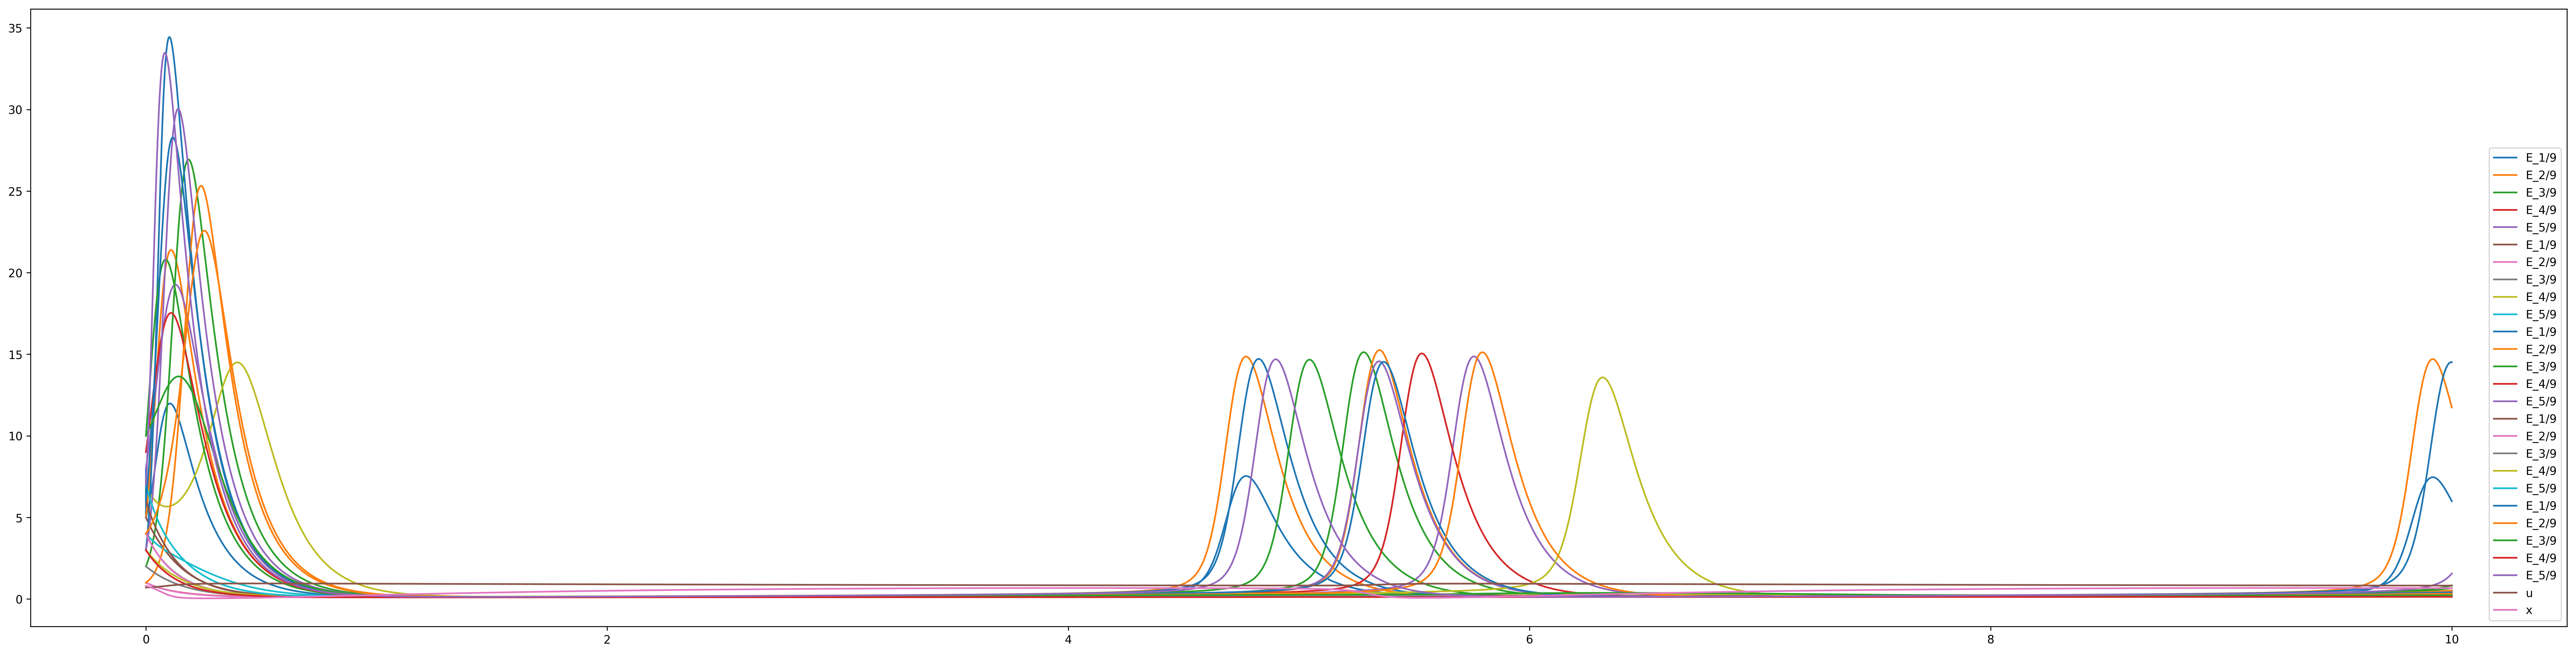

In [107]:
plot_results(300, 0, 10)

In [15]:
plot_3d_color_surface(10, 800, 'results10timesscaled_scalefactor10_800-900_bugfixed')

~0/10 sec completed
~1/10 sec completed
~2/10 sec completed
~3/10 sec completed
~4/10 sec completed
~5/10 sec completed
~6/10 sec completed
~7/10 sec completed
~8/10 sec completed
~9/10 sec completed
finished !


In [ ]:
# checking ratio inside current : external current
for i in range(int(T) - 1):
    time[i+1] = i * dt
    i = int(9*(1/dt))
    for grid_index_i in range(num_grid):
        for grid_index_j in range(num_grid):
            print("E_t{}{}={}".format(grid_index_i+1, grid_index_j+1, E_t[i, grid_index_i+1,grid_index_j+1]))
            print("inside current {} : external current {}".format(J*u_t[i,grid_index_i+1,grid_index_j+1]*x_t[i,grid_index_i+1,grid_index_j+1]\
                                *E_t[i,grid_index_i+1,grid_index_j+1]\
                                ,c[grid_index_i+1-1, grid_index_j+1, 2] * E_t[i, grid_index_i+1-1, grid_index_j+1]\
                                + c[grid_index_i+1, grid_index_j+1+1, 3] * E_t[i, grid_index_i+1, grid_index_j+1+1]\
                                + c[grid_index_i+1+1, grid_index_j+1, 0] * E_t[i, grid_index_i+1+1, grid_index_j+1]\
                                + c[grid_index_i+1, grid_index_j+1-1, 1] * E_t[i, grid_index_i+1, grid_index_j+1-1]
                                ))
    key = input("progress")